num train: 2034
num test : 1353
X_train shape: (2034, 64)
Y_train shape: (2034,)
X_test shape: (1353, 64)
Y_test shape: (1353,)
model 1
Accuracy 0.416112 = 563 / 1353
model 2
Accuracy 0.450111 = 609 / 1353
model 3
Accuracy 0.566888 = 767 / 1353
model 4
Accuracy 0.608278 = 823 / 1353
model 5
Accuracy 0.600887 = 813 / 1353
num layer: 3
num iterations: 7000
active func: tanh
num node: [4, 8, 16, 32, 64]
learn rate: 1e-06
update method: step
reg para: 0.2


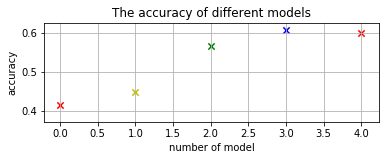

In [3]:
#! -*-coding:utf8-*-
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


reg_lambda = 0.001
epsilon = 0.000001
epsilon_base = 0.000001
num_examples = 0
num_passes = 7000
gamma = 0.2


def plot_result(loss_arr, acc_arr, layer_arr, name):
    loss_result_reshape = np.array(loss_arr).T

    ax = plt.subplot(111)
    for i in range(len(layer_arr)):
        ax.plot(loss_result_reshape[:, i], label='number of %i model' % i)

    plt.legend()
    plt.grid(True)  # 增加格点
    plt.axis('tight')  # 坐标轴适应数据量 axis 设置坐标轴
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('The loss of different models')
    plt.savefig('The loss %s' % name)

    ax = plt.subplot(211)
    colors = ['r', 'y', 'g', 'b', 'r', 'y', 'g', 'b', 'orange']
    for i in range(len(layer_arr)):
        #     ax.plot(label='number of layer %i' %input_dim[i])
        plt.scatter(i, acc_arr[i], c=colors[i % 4], cmap='brg', s=40, marker='x')
        #     plt.legend('number of layer %i' %input_dim[i])

    plt.grid(True)  # 增加格点
    plt.axis('tight')  # 坐标轴适应数据量 axis 设置坐标轴
    plt.xlabel('number of model')
    plt.ylabel('accuracy')
    plt.title('The accuracy of different models')
    plt.savefig('The accuracy %s' % name)


def fetch_data():
    categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

    newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
    newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

    # pprint(newsgroups_train.data[0])

    num_train = len(newsgroups_train.data)
    num_test = len(newsgroups_test.data)

    print('num train:',num_train)
    print('num test :',num_test)

    vectorizer = TfidfVectorizer(max_features=64)

    x = vectorizer.fit_transform(newsgroups_train.data + newsgroups_test.data)
    x_train = x[0:num_train, :]
    x_test = x[num_train:num_train + num_test, :]

    y_train = newsgroups_train.target
    y_test = newsgroups_test.target

    print('X_train shape:',x_train.shape)
    print('Y_train shape:',y_train.shape)

    print('X_test shape:',x_test.shape)
    print('Y_test shape:',y_test.shape)

    return x_train, y_train, x_test, y_test


def update_learn_rate(rate, method="fixed", iters=0):
    if method == "step":
        rate *= np.power(gamma, (iters/num_passes))
    elif method == "exp":
        rate *= np.power(gamma, iters)
    elif method == "inv":
        pass
        # rate *= np.power((1 + gamma * iters), (-power))
    else:
        pass


class init_m(object):
    def __init__(self, m_x):
        self.a = m_x


class end_m(object):
    def __init__(self, e_x):
        self.a = e_x


class softmax(object):
    def __init__(self, in_dim, out_dim):
        self.w = np.random.randn(in_dim, out_dim) / np.sqrt(in_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = None
        self.db = None
        self.delta = None
        self.z = None
        self.a = None

    def forward(self, f_x):
        self.z = f_x.dot(self.w) + self.b
        exp_scores = np.exp(self.z)
        self.a = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.a

    def backprop(self, font_layer, back_layer):
        self.delta = self.a
        self.delta[range(num_examples), back_layer.a] -= 1
        self.dw = font_layer.a.T.dot(self.delta)
        self.db = np.sum(self.delta, axis=0, keepdims=True)

        self.dw += reg_lambda * self.w
        self.w += -epsilon * self.dw
        self.b += -epsilon * self.db


class relu(object):
    def __init__(self, in_dim, out_dim):
        self.w = np.random.randn(in_dim, out_dim) / np.sqrt(in_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = None
        self.db = None
        self.delta = None
        self.z = None
        self.a = None
        self.grad = None

    def forward(self, f_x):
        self.z = f_x.dot(self.w) + self.b
        self.a = np.where(self.z < 0, 0, self.z)
        self.grad = np.where(self.a < 0, 0, 1)
        return self.a

    def backprop(self, font_layer, back_layer):
        self.delta = back_layer.delta.dot(back_layer.w.T) * self.grad
        self.dw = font_layer.a.T.dot(self.delta)
        self.db = np.sum(self.delta, axis=0, keepdims=True)

        self.dw += reg_lambda * self.w
        self.w += -epsilon * self.dw
        self.b += -epsilon * self.db


class l_tanh(object):
    def __init__(self, in_dim, out_dim):
        self.w = np.random.randn(in_dim, out_dim) / np.sqrt(in_dim)
        self.b = np.zeros((1, out_dim))
        self.dw = None
        self.db = None
        self.delta = None
        self.z = None
        self.a = None
        self.grad = None

    def forward(self, f_x):
        self.z = f_x.dot(self.w) + self.b
        self.a = np.tanh(self.z)
        self.grad = 1 - np.power(self.a, 2)
        return self.a

    def backprop(self, font_layer, back_layer):
        self.delta = back_layer.delta.dot(back_layer.w.T) * self.grad
        self.dw = font_layer.a.T.dot(self.delta)
        self.db = np.sum(self.delta, axis=0, keepdims=True)

        self.dw += reg_lambda * self.w
        self.w += -epsilon * self.dw
        self.b += -epsilon * self.db


class MLP(object):

    def __init__(self):
        self.layers = [relu(20, 4),
                       relu(4, 4),
                       relu(4, 4),
                       relu(4, 4),
                       softmax(4, 20)]
        self._loss = 1000
        self.loss_result = []
        self.accuracy = 0.0
        self.learn_rate_method = "fixed"

    def forward(self, f_x):
        tmp = f_x
        for layer in self.layers:
            tmp = layer.forward(tmp)
        return tmp

    def loss(self, l_x, y):
        l_x = self.forward(l_x)

        # Calculating the loss
        corect_logprobs = -np.log(l_x[range(num_examples), y])
        data_loss = np.sum(corect_logprobs)
        # Add regulatization term to loss (optional)
        w_sum = 0
        for layer in self.layers:
            w_sum += np.sum(np.square(layer.w))

        data_loss += reg_lambda / 2 * w_sum
        self._loss = 1. / num_examples * data_loss

    def train(self, t_x, y):

        self.loss_result = []
        for passes in range(0, num_passes):
            self.loss(t_x, y)
            if passes % 10 == 0:
                self.loss_result.append(self._loss)
                if passes % 1000 == 0:
                    pass
                    #print("Loss after iteration %i: %f" % (passes, self._loss))

            for i in range(len(self.layers)):
                if i == 0:
                    self.layers[-i - 1].backprop(self.layers[-i - 2], end_m(y))
                elif i == len(self.layers) - 1:
                    self.layers[-i - 1].backprop(init_m(t_x), self.layers[-i])
                else:
                    self.layers[-i - 1].backprop(self.layers[-i - 2], self.layers[-i])
            update_learn_rate(epsilon, self.learn_rate_method, passes)

    def predict(self, _x, _y):
        n_correct = 0
        n_test = _x.shape[0]
        for n in range(n_test):
            xp = _x[n, :]
            yp = np.argmax(self.forward(xp), axis=1)
            if yp == _y[n]:
                n_correct += 1.0

        self.accuracy = n_correct / n_test
        print('Accuracy %f = %d / %d' % (self.accuracy, int(n_correct), n_test))


def save_result():
    pass

def print_msg(num_node, epsilon, method, gamma, layer=3, num_pass=7000, active_func='tanh'):
    print('num layer:',layer)
    print('num iterations:',num_pass)

    print('active func:',active_func)
    print('num node:',num_node)

    print('learn rate:',epsilon)
    print('update method:',method)

    print('reg para:',gamma)




if __name__ == '__main__':
    X_train, Y_train, X_test, Y_test = fetch_data()
    num_examples, input_dim = X_train.shape
    Loss = []
    Acc = []
    Layer = []
    np.random.seed(0)
    layers = [[l_tanh(64, 4), l_tanh(4, 4), l_tanh(4, 4), l_tanh(4, 4), softmax(4, 4)],
              [l_tanh(64, 8), l_tanh(8, 8), l_tanh(8, 8), l_tanh(8, 8), softmax(8, 4)],
              [l_tanh(64, 16), l_tanh(16, 16), l_tanh(16, 16), l_tanh(16, 16), softmax(16, 4)],
              [l_tanh(64, 32), l_tanh(32, 32), l_tanh(32, 32), l_tanh(32, 32), softmax(32, 4)],
              [l_tanh(64, 64), l_tanh(64, 64), l_tanh(64, 64), l_tanh(64, 64), softmax(64, 4)]
#               [l_tanh(64, 128), l_tanh(128, 128), l_tanh(128, 128), l_tanh(128, 128), softmax(128, 4)]
#               [l_tanh(32, 256), l_tanh(256, 256), l_tanh(256, 256), l_tanh(256, 256), softmax(256, 4)]
              ]
    Model = MLP()


    # 每次运行之前修改一下要保存的图片名称
    pic_name = "New feayure Tanh and epsilon:%i step for 3 layers " %(epsilon_base)
    num_node = [4, 8, 16, 32, 64]

    index = 1
    for la in layers:
        print('model %d'%(index))
        index += 1

        epsilon = epsilon_base
        Model.layers = la 
        #修改学习速率的改变方式 "fixed" “step”  “exp"
        Model.learn_rate_method = "step"

        Model.train(X_train, Y_train)
        Loss.append(Model.loss_result)
        Layer.append(len(la) - 1)

        Model.predict(X_test, Y_test)
        Acc.append(Model.accuracy)

    plot_result(Loss, Acc, Layer, pic_name)
    print_msg(num_node, epsilon_base, Model.learn_rate_method, gamma)


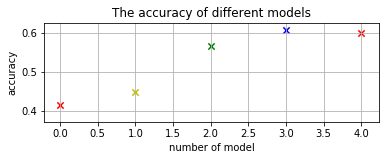

In [4]:
    plot_result(Loss, Acc, Layer, pic_name)